# Import data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from inspect import signature
from sklearn.model_selection import KFold
from typing import Callable, Tuple, List


# data_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML2/test.csv')
# data_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML2/train.csv')

data_test = pd.read_csv('/content/drive/MyDrive/Data/radiotechnics_prediction/test.csv')
data_train = pd.read_csv('/content/drive/MyDrive/Data/radiotechnics_prediction/train.csv')

In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354 entries, 0 to 1353
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1354 non-null   int64  
 1   element  1354 non-null   int64  
 2   U        1354 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 31.9 KB


In [ ]:
# Cut train data at 2, 3, 4 cases U > 0
# data_train = data_train[(data_train['element'] == 1) | ((data_train['element'] != 1) & (data_train['U'] > 0))]

el_num = len(data_train['element'].drop_duplicates())

for i in range(1, el_num + 1):
    query_str = f'data_train_full_{i} = data_train[data_train.element == i]'
    exec(query_str)
    query_str = f'data_test_full_{i} = data_test[data_test.element == i]'
    exec(query_str)

# Row data

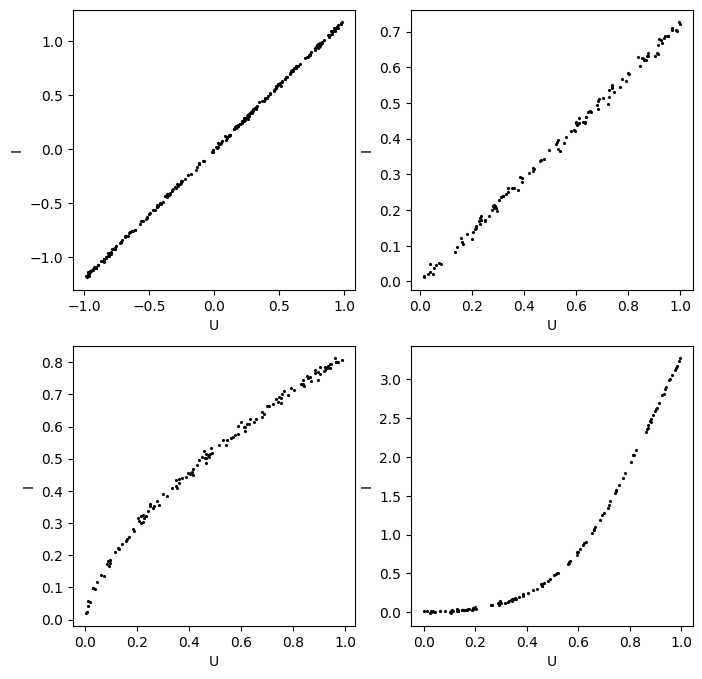

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0, 0].set_xlabel('U')
ax[0, 0].set_ylabel('I')
ax[0, 0].scatter(data_train_full_1['U'], data_train_full_1['I'], marker='*', s=2, linestyle='-', c='black')
ax[0, 1].set_xlabel('U')
ax[0, 1].set_ylabel('I')
ax[0, 1].scatter(data_train_full_2['U'], data_train_full_2['I'], marker='*', s=2, linestyle='-', c='black')
ax[1, 0].set_xlabel('U')
ax[1, 0].set_ylabel('I')
ax[1, 0].scatter(data_train_full_3['U'], data_train_full_3['I'], marker='*', s=2, linestyle='-', c='black')
ax[1, 1].set_xlabel('U')
ax[1, 1].set_ylabel('I')
ax[1, 1].scatter(data_train_full_4['U'], data_train_full_4['I'], marker='*', s=2, linestyle='-', c='black')

(array([46., 14.,  9.,  6.,  4.,  4.,  4.,  3.,  3.,  3.,  2.,  2.,  3.,
         0.,  5.,  4.,  3.,  4.,  3.,  5.]),
 array([-0.01030902,  0.15373063,  0.31777027,  0.48180992,  0.64584957,
         0.80988921,  0.97392886,  1.13796851,  1.30200815,  1.4660478 ,
         1.63008744,  1.79412709,  1.95816674,  2.12220638,  2.28624603,
         2.45028568,  2.61432532,  2.77836497,  2.94240462,  3.10644426,
         3.27048391]),
 <BarContainer object of 20 artists>)

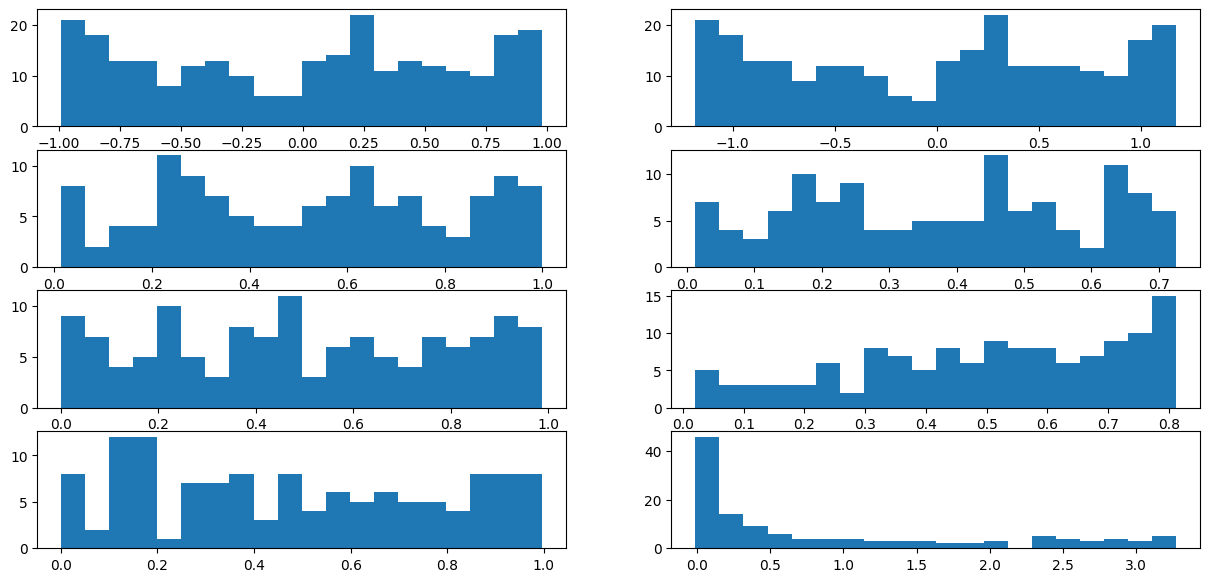

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(15, 7))

ax[0, 0].hist(np.array(data_train_full_1['U']), bins=20)
ax[0, 1].hist(np.array(data_train_full_1['I']), bins=20)

ax[1, 0].hist(np.array(data_train_full_2['U']), bins=20)
ax[1, 1].hist(np.array(data_train_full_2['I']), bins=20)

ax[2, 0].hist(np.array(data_train_full_3['U']), bins=20)
ax[2, 1].hist(np.array(data_train_full_3['I']), bins=20)

ax[3, 0].hist(np.array(data_train_full_4['U']), bins=20)
ax[3, 1].hist(np.array(data_train_full_4['I']), bins=20)

(array([20., 31., 28., 27., 22., 18., 24., 28., 31., 18., 14., 19., 19.,
        12.,  7., 11., 14., 12.,  9.,  9.]),
 array([-0.99993856, -0.90024669, -0.80055482, -0.70086295, -0.60117108,
        -0.50147921, -0.40178734, -0.30209547, -0.2024036 , -0.10271173,
        -0.00301986,  0.09667201,  0.19636388,  0.29605575,  0.39574762,
         0.49543949,  0.59513136,  0.69482323,  0.7945151 ,  0.89420696,
         0.99389883]),
 <BarContainer object of 20 artists>)

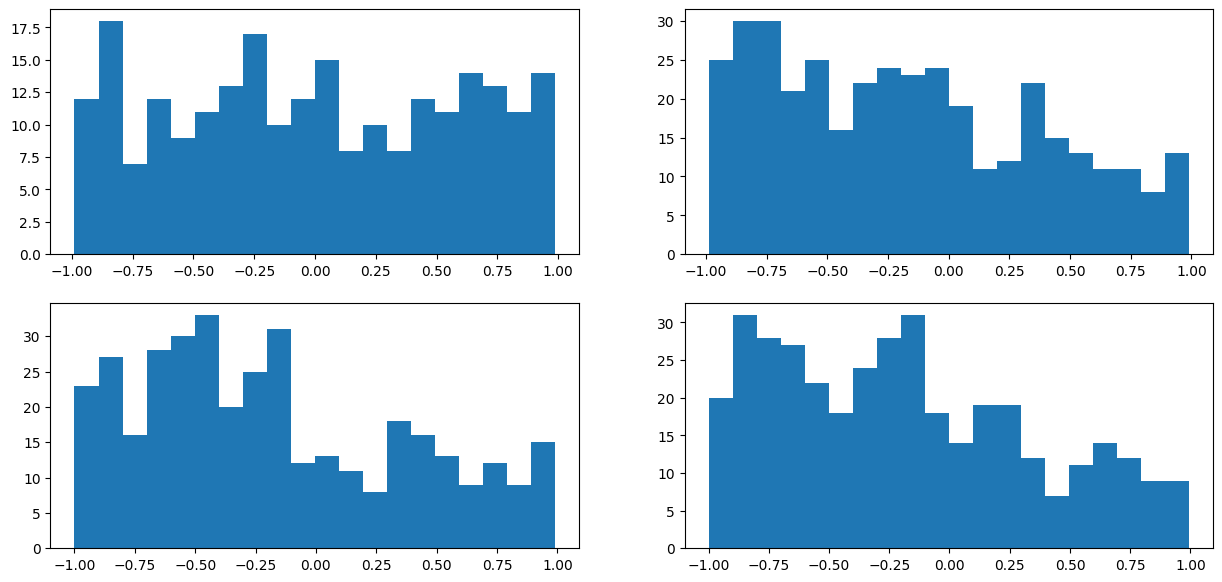

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 7))

ax[0, 0].hist(np.array(data_test_full_1['U']), bins=20)
ax[0, 1].hist(np.array(data_test_full_2['U']), bins=20)
ax[1, 0].hist(np.array(data_test_full_3['U']), bins=20)
ax[1, 1].hist(np.array(data_test_full_4['U']), bins=20)


# Model class

In [ ]:
class UniverseModel:

    """
    X function
    Minimize fit
    """

    def __init__(self, function):
        self.function = function
        self.param = None
        # Get number of parameters from function signature
        sig = signature(function)
        self.n_params = len(sig.parameters) - 1  # Subtract 1 for the x parameter


    def fit(self, u: np.ndarray, i: np.ndarray) -> np.ndarray:

        def to_minimize(coef):
            return np.sum((i - self.function(u, *coef))**2)

        # Generate initial guess based on detected parameter count
        coef0 = np.random.rand(self.n_params)
        result = minimize(to_minimize, coef0)

        if result.success:
            self.param = result.x
            return self.param
        else:
            raise ValueError(f"Optimization failed: {result.message}")


    def predict(self, u):
        if self.param is None:
            raise ValueError("Model must be fitted first")
        return self.function(u, *self.param)


# K-fold validation function


In [ ]:
def k_fold_valid(
    model_func: Callable,
    u: np.ndarray,
    i: np.ndarray,
    n_splits: int
) -> Tuple[List, List]:

    """
    k-fold validation with given function as a model

    return lists of test mse and models from k folds
    """

    kf = KFold(n_splits=6, shuffle=True, random_state=42)

    model_list = []
    mse_list = []

    for fold, (train_index, test_index) in enumerate(kf.split(u)):
        u_train, u_test, i_train, i_test = u[train_index], u[test_index], i[train_index], i[test_index]

        model = UniverseModel(model_func)

        model.fit(u_train, i_train)

        # Make the predictions for u_test
        i_test_pred = model.predict(u_test)

        mse_test = np.mean((i_test - i_test_pred)**2)

        model_list.append(model)
        mse_list.append(mse_test)

    return model_list, mse_list

# Boost model

In [ ]:
# Boost model
def boost_model(model_list: List, u: np.ndarray) -> np.ndarray:
    predictions = []
    for model in model_list:
        predictions.append(model.predict(u))

    predictions = np.array(predictions)

    res_pred = np.sum(predictions, axis=0) / len(predictions)

    return res_pred

# Model 1 validation


MSE list: 
6.397187281159188e-05
8.274206147304615e-05
9.627691422417442e-05
0.0001561584772183249
8.93056682547074e-05
8.554186340358395e-05

Mean MSE: 9.566614289757144e-05


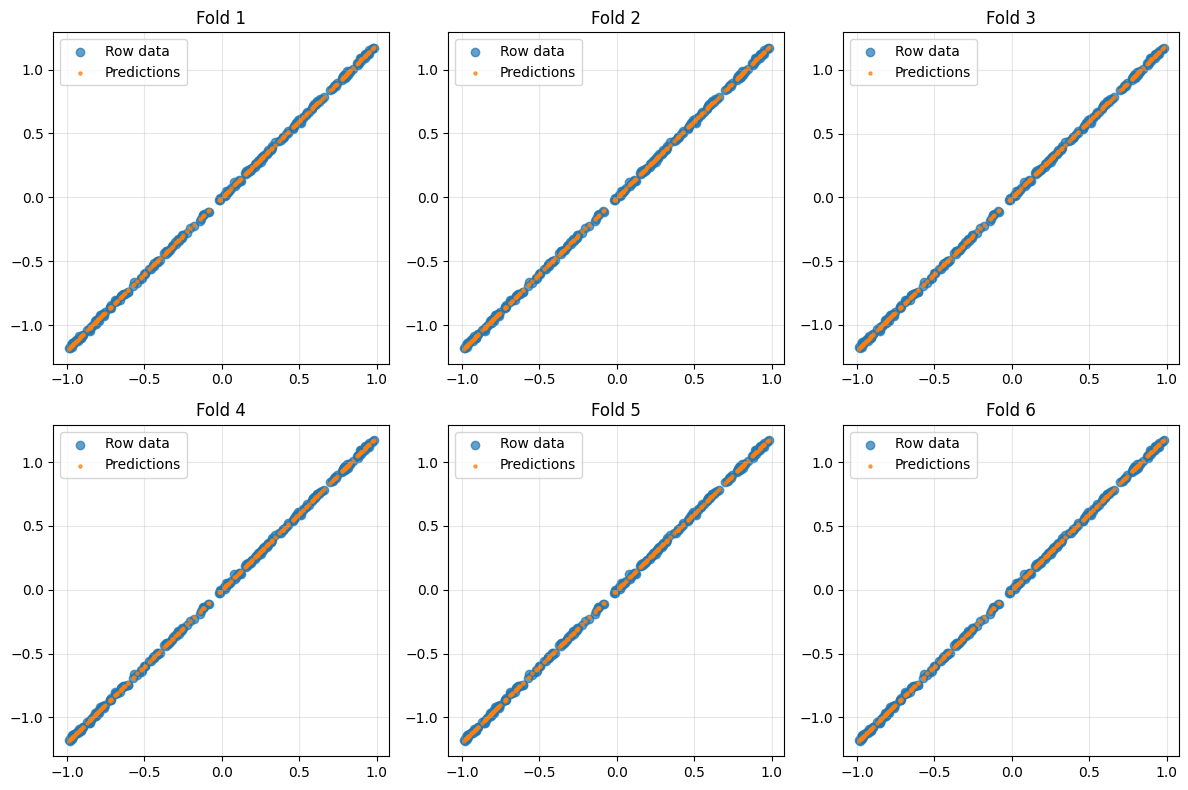

In [ ]:
# Model function
def f_el_1(x, a, b):
    return a + b * x

# Train data
u = np.array(data_train_full_1['U'])
i = np.array(data_train_full_1['I'])

n_splits = 6

# k-fold validation
model_list, mse_list = k_fold_valid(f_el_1, u, i, n_splits)


print('MSE list: ')
for mse in mse_list:
    print(mse)

print(f'\nMean MSE: {np.mean(mse_list)}')

# Plotting
n_models = len(model_list)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for num in range(n_models):
    axes[num].scatter(u, i, label='Row data', alpha=0.7)
    axes[num].scatter(u, model_list[num].predict(u), label='Predictions', alpha=0.7, s=5)
    axes[num].set_title(f'Fold {num+1}')
    axes[num].legend()
    axes[num].grid(True, alpha=0.3)

for num in range(n_models, len(axes)):
    axes[num].set_visible(False)

plt.tight_layout()
plt.show()

# Model 1 final evaluation

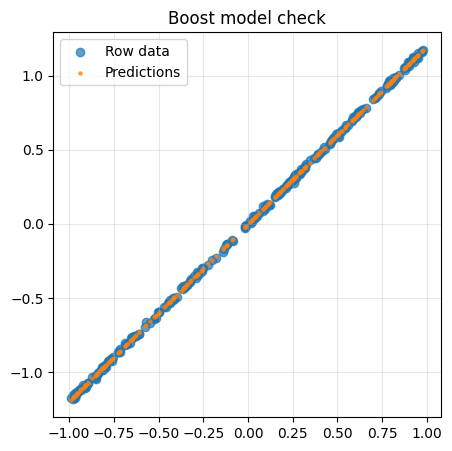

In [ ]:
# Train on full dataset
u = np.array(data_train_full_1['U'])
i = np.array(data_train_full_1['I'])

model_1_full = UniverseModel(f_el_1)
model_1_full.fit(u, i)

# Boost model
model_list_1 = model_list
boost_model_1 = boost_model

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(u, i, label='Row data', alpha=0.7)
ax.scatter(u, boost_model_1(model_list_1, u), label='Predictions', alpha=0.7, s=5)
ax.set_title(f'Boost model check')
ax.legend()
ax.grid(True, alpha=0.3)

# Process model 2

MSE list: 
0.00011236035599886891
0.00010101273105349424
8.376873715154442e-05
7.574987421308728e-05
0.0001349416481265595
8.639424517983084e-05

Mean MSE: 9.903793195389752e-05


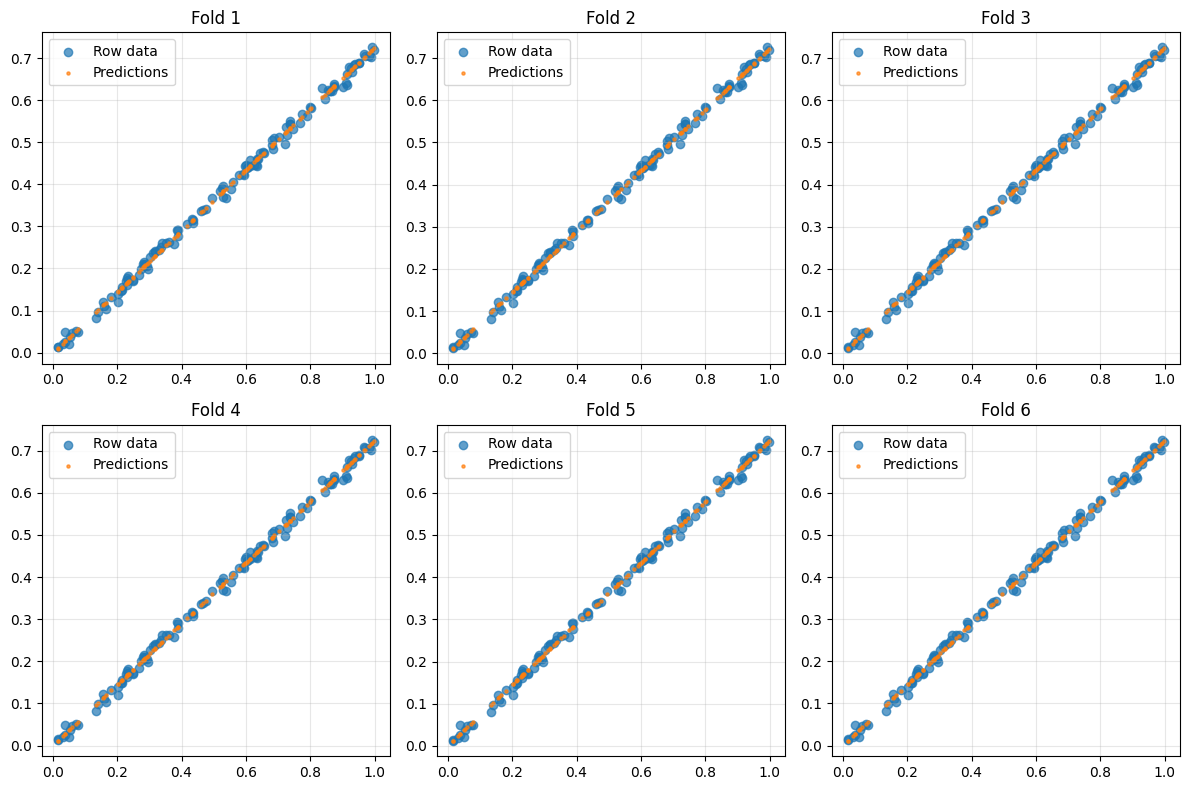

In [ ]:
# Model function
def f_el_2(x, a, b):
    return a + b * x

# Train data
u = np.array(data_train_full_2['U'])
i = np.array(data_train_full_2['I'])

n_splits = 6

# k-fold validation
model_list, mse_list = k_fold_valid(f_el_2, u, i, n_splits)


print('MSE list: ')
for mse in mse_list:
    print(mse)

print(f'\nMean MSE: {np.mean(mse_list)}')

# Plotting
n_models = len(model_list)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for num in range(n_models):
    axes[num].scatter(u, i, label='Row data', alpha=0.7)
    axes[num].scatter(u, model_list[num].predict(u), label='Predictions', alpha=0.7, s=5)
    axes[num].set_title(f'Fold {num+1}')
    axes[num].legend()
    axes[num].grid(True, alpha=0.3)

for num in range(n_models, len(axes)):
    axes[num].set_visible(False)

plt.tight_layout()
plt.show()

# Model 2 final evaluation

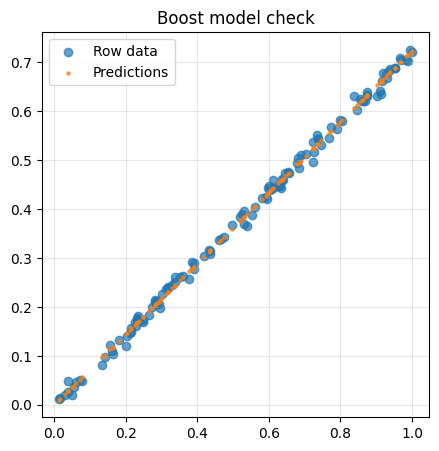

In [ ]:
# Train on full dataset
u = np.array(data_train_full_2['U'])
i = np.array(data_train_full_2['I'])

model_2_full = UniverseModel(f_el_2)
model_2_full.fit(u, i)

# Boost model
model_list_2 = model_list
boost_model_2 = boost_model

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(u, i, label='Row data', alpha=0.7)
ax.scatter(u, boost_model_2(model_list_2, u), label='Predictions', alpha=0.7, s=5)
ax.set_title(f'Boost model check')
ax.legend()
ax.grid(True, alpha=0.3)

# Process model 3

MSE list: 
0.00014303471725273195
9.7958394958026e-05
5.586222820328384e-05
8.240576182439443e-05
7.955572659527918e-05
7.389313866769631e-05

Mean MSE: 8.878499458356863e-05


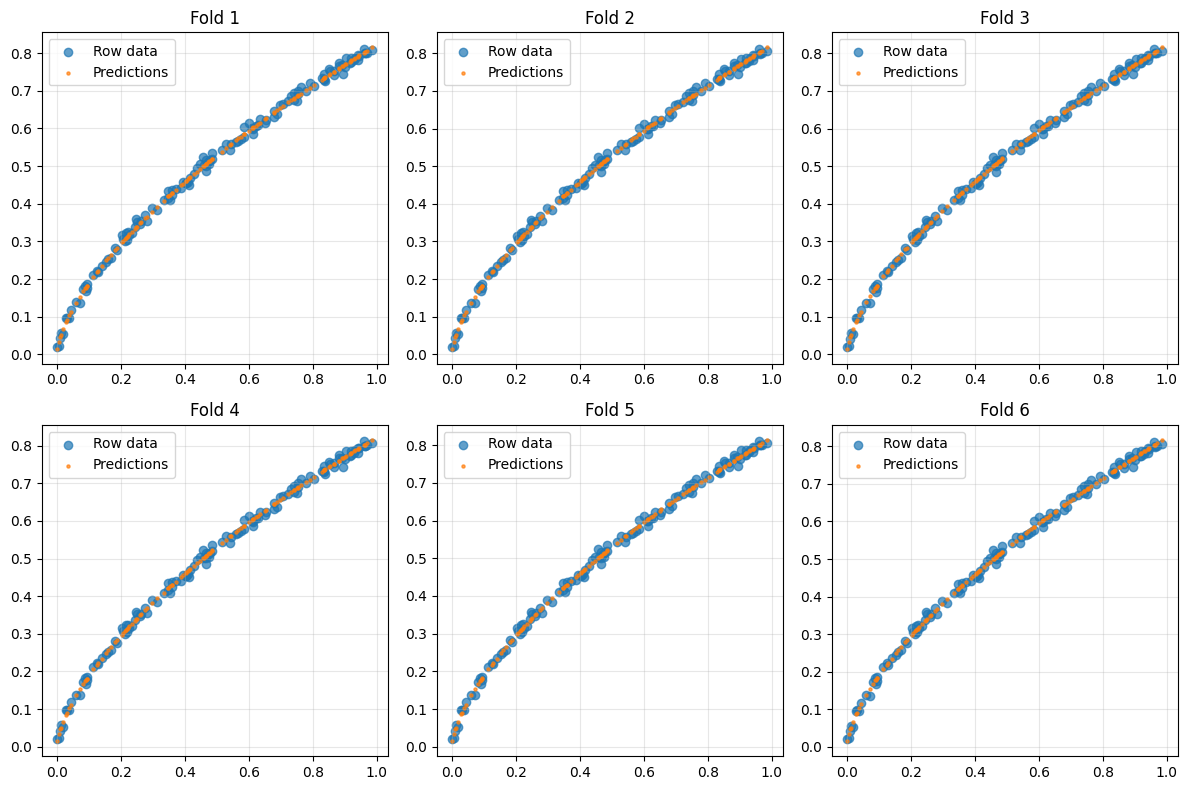

In [ ]:
# Model function
def f_el_3(x, a, b, c):
    y = np.sign(x) * x
    return np.sign(x) * (a * np.sqrt(y) * np.exp(-y) + (b * y + c) * (1 - np.exp(-y)))

# Train data
u = np.array(data_train_full_3['U'])
i = np.array(data_train_full_3['I'])

n_splits = 6

# k-fold validation
model_list, mse_list = k_fold_valid(f_el_3, u, i, n_splits)


print('MSE list: ')
for mse in mse_list:
    print(mse)

print(f'\nMean MSE: {np.mean(mse_list)}')

# Plotting
n_models = len(model_list)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for num in range(n_models):
    axes[num].scatter(u, i, label='Row data', alpha=0.7)
    axes[num].scatter(u, model_list[num].predict(u), label='Predictions', alpha=0.7, s=5)
    axes[num].set_title(f'Fold {num+1}')
    axes[num].legend()
    axes[num].grid(True, alpha=0.3)

for num in range(n_models, len(axes)):
    axes[num].set_visible(False)

plt.tight_layout()
plt.show()

# Model 3 final evaluation

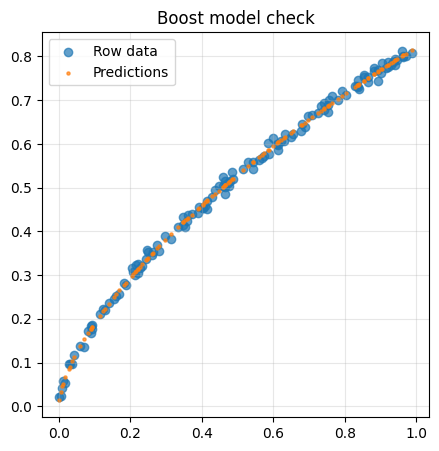

In [ ]:
# Train on full dataset
u = np.array(data_train_full_3['U'])
i = np.array(data_train_full_3['I'])

model_3_full = UniverseModel(f_el_3)
model_3_full.fit(u, i)

# Boost model
model_list_3 = model_list
boost_model_3 = boost_model

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(u, i, label='Row data', alpha=0.7)
ax.scatter(u, boost_model_3(model_list_3, u), label='Predictions', alpha=0.7, s=5)
ax.set_title(f'Boost model check')
ax.legend()
ax.grid(True, alpha=0.3)

# Process model 4

MSE list: 
0.0010408531661651942
0.0010026127908709325
0.0008654793348838455
0.0007093299461754592
0.001235757639592435
0.0005002524398403197

Mean MSE: 0.0008923808862546979


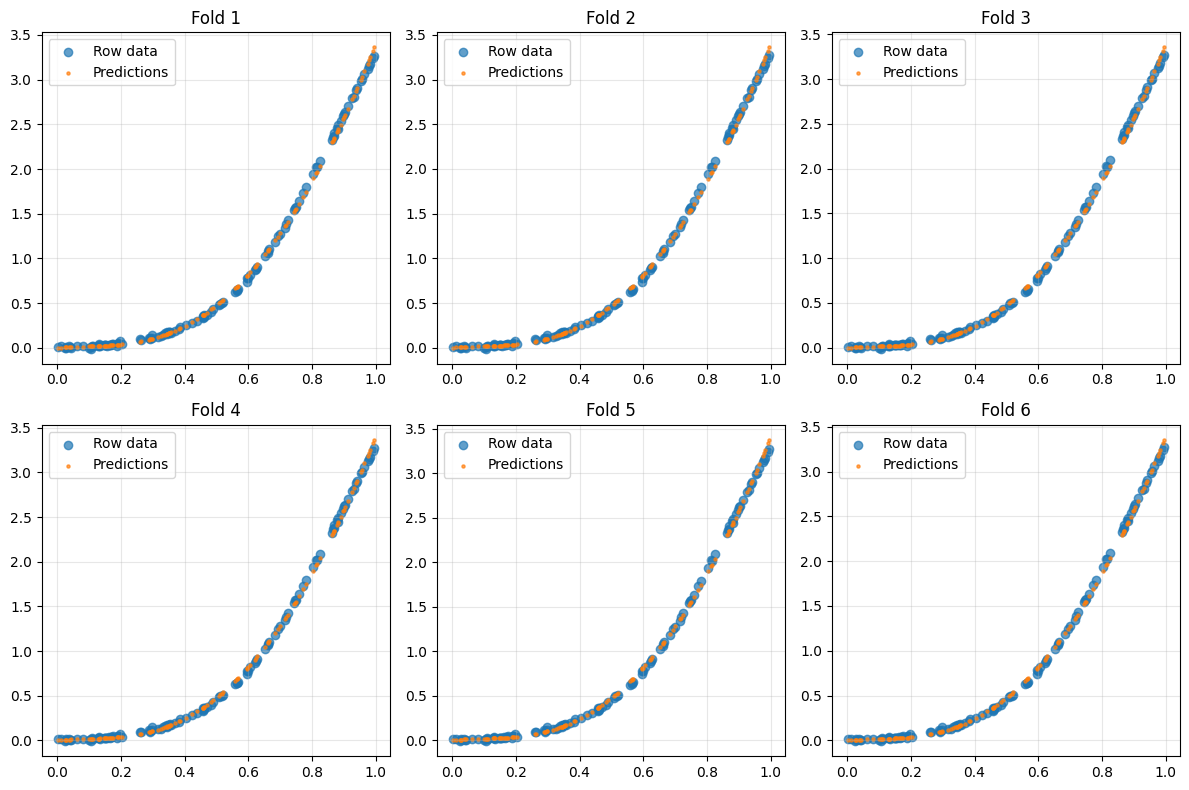

In [ ]:
# Model function
def f_el_4(x, a, b, c, d):
    return (a * x**2 * np.exp(-x) + (b * x + c) * (1 - np.exp(-x))) * (x > 0)
    # return a * (np.exp(b *x) - 1)
    # return a * x ** d * np.exp(-x) + (b * x + c) * (1 - np.exp(-x))

# Train data
u = np.array(data_train_full_4['U'])
i = np.array(data_train_full_4['I'])

n_splits = 6

# k-fold validation
model_list, mse_list = k_fold_valid(f_el_4, u, i, n_splits)


print('MSE list: ')
for mse in mse_list:
    print(mse)

print(f'\nMean MSE: {np.mean(mse_list)}')

# Plotting
n_models = len(model_list)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for num in range(n_models):
    axes[num].scatter(u, i, label='Row data', alpha=0.7)
    axes[num].scatter(u, model_list[num].predict(u), label='Predictions', alpha=0.7, s=5)
    axes[num].set_title(f'Fold {num+1}')
    axes[num].legend()
    axes[num].grid(True, alpha=0.3)

for num in range(n_models, len(axes)):
    axes[num].set_visible(False)

plt.tight_layout()
plt.show()

# Model 4 final evaluation

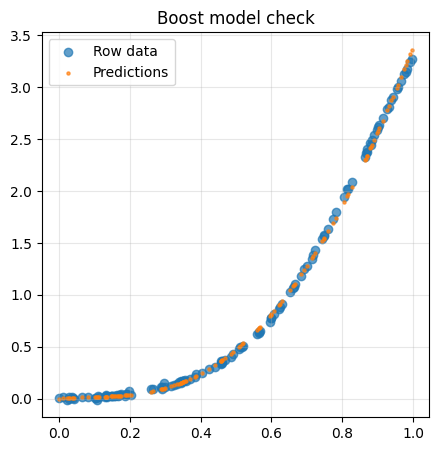

In [ ]:
# Train on full dataset
u = np.array(data_train_full_4['U'])
i = np.array(data_train_full_4['I'])

model_4_full = UniverseModel(f_el_4)
model_4_full.fit(u, i)

# Boost model
model_list_4 = model_list
boost_model_4 = boost_model

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(u, i, label='Row data', alpha=0.7)
ax.scatter(u, boost_model_4(model_list_4, u), label='Predictions', alpha=0.7, s=5)
ax.set_title(f'Boost model check')
ax.legend()
ax.grid(True, alpha=0.3)

# Submission file

In [ ]:
# Removed data
# data_test_bad = data_test[(data_test['element'] > 2) & (data_test['U'] <= 0)]
# Cut test data for 2, 3, 4 cases U > 0
# data_test = data_test[(data_test['element'] == 1) | ((data_test['element'] != 1) & (data_test['U'] > 0))]


u_1 = np.array(data_test_full_1['U'])
u_2 = np.array(data_test_full_2['U'])
u_3 = np.array(data_test_full_3['U'])
u_4 = np.array(data_test_full_4['U'])

i_1 = model_1_full.predict(u_1)
i_2 = model_2_full.predict(u_2)
i_3 = model_3_full.predict(u_3)
i_4 = model_4_full.predict(u_4)

i = np.concatenate([i_1, i_2, i_3, i_4])

res_data_1 = pd.DataFrame(i, columns=['I'])
res_data_1.index.name = 'id'
res_data_1.insert(0, 'id', res_data_1.index)
res_data_1 = res_data_1.reset_index(drop=True)

i_1 = boost_model_1(model_list_1, u_1)
i_2 = boost_model_2(model_list_2, u_2)
i_3 = boost_model_3(model_list_3, u_3)
i_4 = boost_model_4(model_list_4, u_4)

i = np.concatenate([i_1, i_2, i_3, i_4])

res_data_2 = pd.DataFrame(i, columns=['I'])
res_data_2.index.name = 'id'
res_data_2.insert(0, 'id', res_data_2.index)
res_data_2 = res_data_2.reset_index(drop=True)

# print(f'{len(data_test)}')
# print(f'{len(res_data_1)}')
# print(f'{len(res_data_2)}')


res_data_1

,id,I
0,0,-0.300575
1,1,-1.058845
2,2,0.242328
3,3,0.498612
4,4,0.796618
...,...,...
1349,1349,-0.000000
1350,1350,-0.000000
1351,1351,0.837927
1352,1352,1.402645


In [76]:
res_data_1.to_csv('/content/drive/MyDrive/Data/radiotechnics_prediction/Submission_full.csv', index=False, encoding='utf-8', sep=',')
res_data_2.to_csv('/content/drive/MyDrive/Data/radiotechnics_prediction/Submission_gen.csv', index=False, encoding='utf-8', sep=',')

In [ ]:
data_ex = pd.read_csv('/content/drive/MyDrive/Data/radiotechnics_prediction/sample_submission.csv')
data_ex

,id,I
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
1349,1349,0
1350,1350,0
1351,1351,0
1352,1352,0
